## Final Project Submission

Please fill out:
* Student name: **Parker Lumkes**
* Student pace: **Full-time**
* Scheduled project review date/time: **TBD**
* Instructor name: **Rafael Carrasco**
* Blog post URL: **TBD**


### Checklist

* Your project contains at least 4 meaningful data visualizations, with corresponding interpretations. All visualizations are well labeled with axes labels, a title, and a legend (when appropriate)
* You pose at least 3 meaningful questions and answer them through EDA. These questions should be well labeled and easy to identify inside the notebook.
* Your model should not include any predictors with p-values greater than .05.
* Your notebook shows an iterative approach to modeling, and details the parameters and results of the model at each iteration.
* You provide at least 1 paragraph explaining your final model.
* You pick at least 3 coefficients from your final model and explain their impact on the price of a house in this dataset.

### Column Definitions

* **id** - unique identified for a house
* **dateDate** - house was sold
* **pricePrice** -  is prediction target
* **bedroomsNumber** -  of Bedrooms/House
* **bathroomsNumber** -  of bathrooms/bedrooms
* **sqft_livingsquare** -  footage of the home
* **sqft_lotsquare** -  footage of the lot
* **floorsTotal** -  floors (levels) in house
* **waterfront** - House which has a view to a waterfront
* **view** - Has been viewed
* **condition** - How good the condition is ( Overall )
* **grade** - overall grade given to the housing unit, based on King County grading system
* **sqft_above** - square footage of house apart from basement
* **sqft_basement** - square footage of the basement
* **yr_built** - Built Year
* **yr_renovated** - Year when house was renovated
* **zipcode** - zip
* **lat** - Latitude coordinate
* **long** - Longitude coordinate
* **sqft_living15** - The square footage of interior housing living space for the nearest 15 neighbors
* **sqft_lot15** - The square footage of the land lots of the nearest 15 neighbors

## Importing libraries & reading-in the data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols

raw_df = pd.read_csv('kc_house_data.csv')

## Cleaning data

### Dropping columns

In [2]:
raw_df.drop('id', axis=1, inplace=True) # unnecessary
raw_df.drop('waterfront', axis=1, inplace=True) # dropped because there were less than 150 positive values
raw_df.drop('view', axis=1, inplace=True) # dropped because 90% of values were 0.0

### Deal with outliers & NaN's

In [3]:
raw_df.drop(raw_df[raw_df.bedrooms > 7].index, inplace=True)
raw_df.drop(raw_df[raw_df.grade > 11].index, inplace=True)
raw_df.drop(raw_df[raw_df.grade ==4].index, inplace=True)
raw_df.drop(raw_df[raw_df.sqft_living > 6000].index, inplace=True)
raw_df.drop(raw_df[raw_df.price > 3850000.0].index, inplace=True)
raw_df.drop(raw_df[raw_df.sqft_lot > 40000].index, inplace=True)
raw_df.drop(raw_df[raw_df.bathrooms > 3.25].index, inplace=True)
raw_df.drop(raw_df[raw_df.bathrooms < 1.00].index, inplace=True)
raw_df.drop(raw_df[raw_df.floors > 2.0].index, inplace=True)
raw_df.drop(raw_df[raw_df.condition < 3].index, inplace=True)
raw_df.drop(raw_df[raw_df.sqft_lot > 30000].index, inplace=True)

In [4]:
raw_df.yr_renovated.fillna(0.0, inplace=True)

### Change date to date-time object

In [5]:
new_date = pd.to_datetime(raw_df.date)

### Change ft<sup>2</sup> basement to float & replace NaN's

In [6]:
raw_df.sqft_basement.replace(to_replace='?', value=100000.0, inplace=True)
raw_df.sqft_basement = raw_df.sqft_basement.astype(float)
raw_df.sqft_basement.replace(to_replace=100000.0, value=np.median(raw_df.sqft_basement), inplace=True)

### Dummy variables for categorical data

In [7]:
bed_dum = pd.get_dummies(raw_df.bedrooms, prefix='bed')
bath_dum = pd.get_dummies(raw_df.bathrooms, prefix='bath')
flr_dum = pd.get_dummies(raw_df.floors, prefix='flr')
cond_dum = pd.get_dummies(raw_df.condition, prefix='cond')
grd_dum = pd.get_dummies(raw_df.grade, prefix='grd')

### Put it all together

In [8]:
raw_df = raw_df.drop(['date', 'bedrooms', 'bathrooms', 'floors', 'condition', 'grade'], axis=1)

In [9]:
raw_df = pd.concat([raw_df, new_date, bed_dum, bath_dum, flr_dum, cond_dum, grd_dum], axis=1)

In [10]:
df = raw_df
df.head()

,price,sqft_living,sqft_lot,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,...,cond_3,cond_4,cond_5,grd_5,grd_6,grd_7,grd_8,grd_9,grd_10,grd_11
0,221900.0,1180,5650,1180,0.0,1955,0.0,98178,47.5112,-122.257,...,1,0,0,0,0,1,0,0,0,0
1,538000.0,2570,7242,2170,400.0,1951,1991.0,98125,47.7210,-122.319,...,1,0,0,0,0,1,0,0,0,0
2,180000.0,770,10000,770,0.0,1933,0.0,98028,47.7379,-122.233,...,1,0,0,0,1,0,0,0,0,0
3,604000.0,1960,5000,1050,910.0,1965,0.0,98136,47.5208,-122.393,...,0,0,1,0,0,1,0,0,0,0
4,510000.0,1680,8080,1680,0.0,1987,0.0,98074,47.6168,-122.045,...,1,0,0,0,0,0,1,0,0,0


In [11]:
target = df['price']

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17890 entries, 0 to 21595
Data columns (total 43 columns):
price            17890 non-null float64
sqft_living      17890 non-null int64
sqft_lot         17890 non-null int64
sqft_above       17890 non-null int64
sqft_basement    17890 non-null float64
yr_built         17890 non-null int64
yr_renovated     17890 non-null float64
zipcode          17890 non-null int64
lat              17890 non-null float64
long             17890 non-null float64
sqft_living15    17890 non-null int64
sqft_lot15       17890 non-null int64
date             17890 non-null datetime64[ns]
bed_1            17890 non-null uint8
bed_2            17890 non-null uint8
bed_3            17890 non-null uint8
bed_4            17890 non-null uint8
bed_5            17890 non-null uint8
bed_6            17890 non-null uint8
bed_7            17890 non-null uint8
bath_1.0         17890 non-null uint8
bath_1.25        17890 non-null uint8
bath_1.5         17890 non-null uint

### Checking for dataframe-wide multicolinearity 

In [13]:
df_possible = df.drop('price', axis=1)

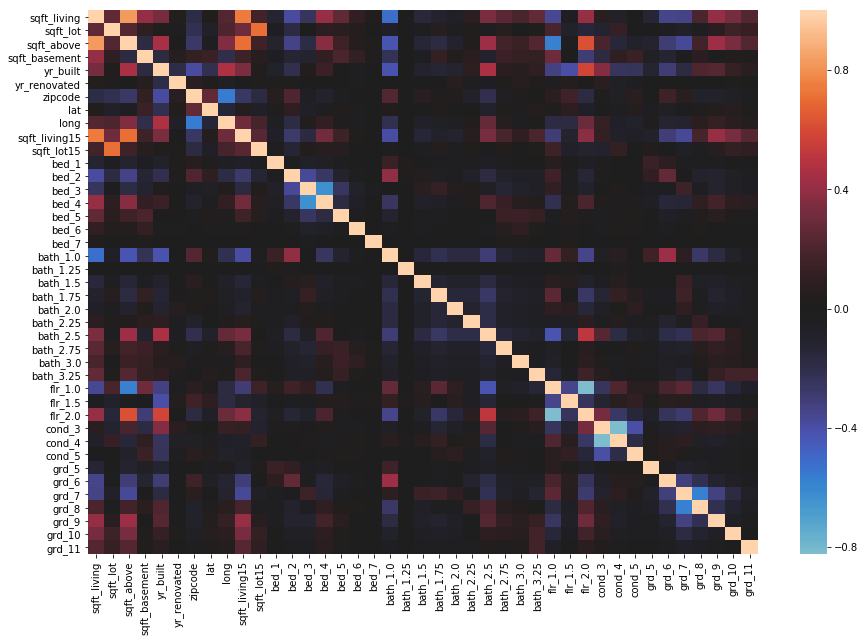

In [14]:
plt.figure(figsize=(15,10))
sns.heatmap(df_possible.corr(), center=0);

> Cleaning the data has caused my dataframe to be large. If I had more time I could be more thorough in seeing which variables are colinear. Instead of testing everyting I will use intuition in some places (for example, assuming the square footage variables for the home itself as well as the 15 neighbors will be highly correlated, as well as shortening the list of possible variables I actually intend to use in the end), and testing in other place (for example when I have determined the variables I want to test, I can make sure there isn't multicolinearity there).

For example:

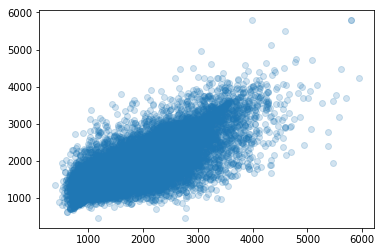

In [15]:
plt.scatter(df.sqft_living, df.sqft_living15, alpha=.2)

> The ft<sup>2</sup> of the home and its '15 counterparts are colinear. 

### Which variables to use in the model?

In [16]:
# Reminder of the variables
df.head()

,price,sqft_living,sqft_lot,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,...,cond_3,cond_4,cond_5,grd_5,grd_6,grd_7,grd_8,grd_9,grd_10,grd_11
0,221900.0,1180,5650,1180,0.0,1955,0.0,98178,47.5112,-122.257,...,1,0,0,0,0,1,0,0,0,0
1,538000.0,2570,7242,2170,400.0,1951,1991.0,98125,47.7210,-122.319,...,1,0,0,0,0,1,0,0,0,0
2,180000.0,770,10000,770,0.0,1933,0.0,98028,47.7379,-122.233,...,1,0,0,0,1,0,0,0,0,0
3,604000.0,1960,5000,1050,910.0,1965,0.0,98136,47.5208,-122.393,...,0,0,1,0,0,1,0,0,0,0
4,510000.0,1680,8080,1680,0.0,1987,0.0,98074,47.6168,-122.045,...,1,0,0,0,0,0,1,0,0,0


### Log-transforming ft<sup>2</sup>

In [147]:
# df.sqft_living = np.log(df.sqft_living)
# df.sqft_lot = np.log(df.sqft_lot)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c1813fcc0>,
      dtype=object)

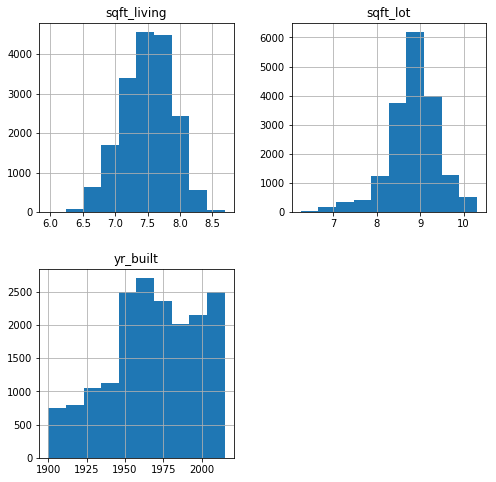

In [142]:
df[['sqft_living', 'sqft_lot', 'yr_built',]].hist(figsize=(8,8))

In [35]:
# creating a function to give me a scatter plot for a variable and our target
def create_plot(variable):
    return plt.scatter(x=df[variable], y=df['price'], alpha=.2);

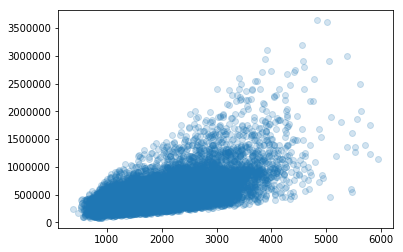

In [48]:
create_plot('sqft_living')

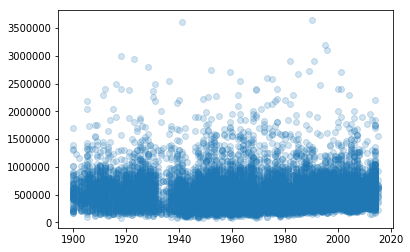

In [72]:
create_plot('yr_built')

> Seems to not have a linear relationship.

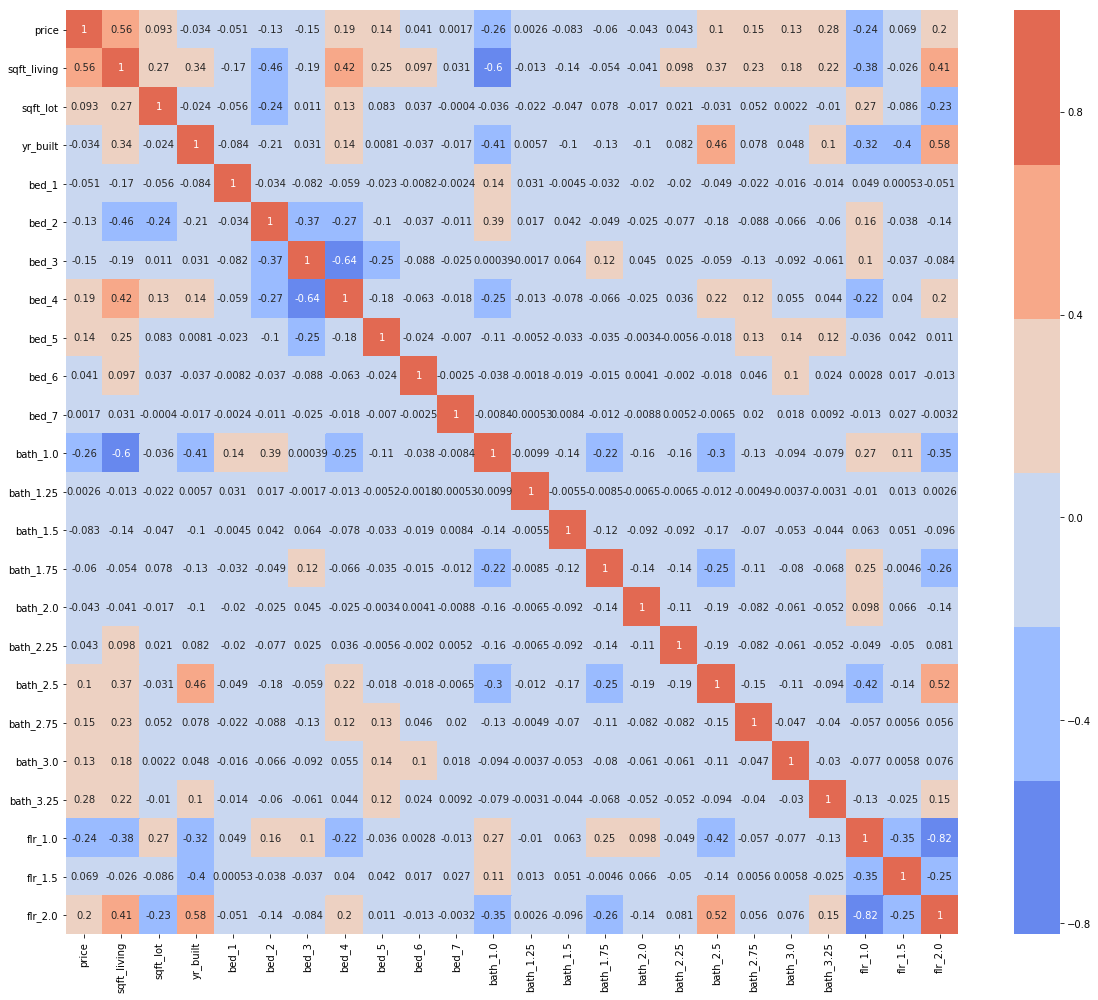

In [260]:
plt.figure(figsize=(20,17))
sns.heatmap(df_pred1.corr(), annot=True, cmap=sns.color_palette('coolwarm'));

> So there is a linear relationship. Let's see what this looks like in an OLS model.

In [256]:
df_pred1 = pd.concat([target, df.loc[:, ['sqft_living', 'sqft_lot', 'yr_built']], bed_dum, bath_dum, flr_dum], axis=1)
df_pred1.head()

,price,sqft_living,sqft_lot,yr_built,bed_1,bed_2,bed_3,bed_4,bed_5,bed_6,...,bath_1.75,bath_2.0,bath_2.25,bath_2.5,bath_2.75,bath_3.0,bath_3.25,flr_1.0,flr_1.5,flr_2.0
0,221900.0,7.073270,8.639411,1955,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,538000.0,7.851661,8.887653,1951,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,1
2,180000.0,6.646391,9.210340,1933,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,604000.0,7.580700,8.517193,1965,0,0,0,1,0,0,...,0,0,0,0,0,1,0,1,0,0
4,510000.0,7.426549,8.997147,1987,0,0,1,0,0,0,...,0,1,0,0,0,0,0,1,0,0


In [210]:
df_pred_test = df_pred1.copy()
df_pred_test.head()

,price,sqft_living,sqft_lot,bed_1,bed_2,bed_3,bed_4,bed_5,bed_6,bed_7,...,bath_1.75,bath_2.0,bath_2.25,bath_2.5,bath_2.75,bath_3.0,bath_3.25,flr_1.0,flr_1.5,flr_2.0
0,221900.0,7.073270,8.639411,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,538000.0,7.851661,8.887653,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
2,180000.0,6.646391,9.210340,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,604000.0,7.580700,8.517193,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,1,0,0
4,510000.0,7.426549,8.997147,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0


In [181]:
target_test = np.log(target)
target_test.head()

0    12.309982
1    13.195614
2    12.100712
3    13.311329
4    13.142166
Name: price, dtype: float64

In [197]:
# df_pred_test.drop(df_pred_test.iloc[:, [0]], axis=1, inplace=True)
df_pred_test = pd.concat([target_test, df_pred_test], axis=1)
df_pred_test.head()

,price,sqft_living,sqft_lot,bed_1,bed_2,bed_3,bed_4,bed_5,bed_6,bed_7,grd_5,grd_6,grd_7,grd_8,grd_9,grd_10,grd_11
0,12.309982,7.073270,8.639411,0,0,1,0,0,0,0,0,0,1,0,0,0,0
1,13.195614,7.851661,8.887653,0,0,1,0,0,0,0,0,0,1,0,0,0,0
2,12.100712,6.646391,9.210340,0,1,0,0,0,0,0,0,1,0,0,0,0,0
3,13.311329,7.580700,8.517193,0,0,0,1,0,0,0,0,0,1,0,0,0,0
4,13.142166,7.426549,8.997147,0,0,1,0,0,0,0,0,0,0,1,0,0,0


In [223]:
df.head(1)

,price,sqft_living,sqft_lot,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,...,cond_3,cond_4,cond_5,grd_5,grd_6,grd_7,grd_8,grd_9,grd_10,grd_11
0,221900.0,7.07327,8.639411,7.07327,0.0,1955,0.0,98178,47.5112,-122.257,...,1,0,0,0,0,1,0,0,0,0


In [228]:
formula = 'price ~ sqft_living'
model = ols(formula=formula, data=df_pred_test).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.315
Model:                            OLS   Adj. R-squared:                  0.315
Method:                 Least Squares   F-statistic:                     8213.
Date:                Sun, 02 Jun 2019   Prob (F-statistic):               0.00
Time:                        16:46:45   Log-Likelihood:            -2.4610e+05
No. Observations:               17890   AIC:                         4.922e+05
Df Residuals:                   17888   BIC:                         4.922e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -2.524e+06   3.33e+04    -75.767      0.000   -2.59e+06   -2.46e+06
sqft_living  4.022e+05   4437.487     90.628      0.000    3.93e+05    4.11e+05
==============================================================================
Omnibus:                     9784.035   Durbin-Watson:                   1.980
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           139284.196
Skew:                           2.322   Prob(JB):                         0.00
Kurtosis:                      15.856   Cond. No.                         149.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

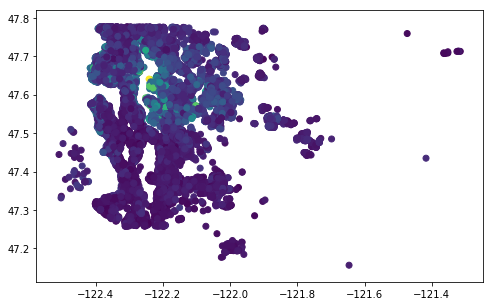

In [274]:
plt.figure(figsize=(8, 5))
plt.scatter(x=df.long, y=df.lat, c=df.price)
plt.show()

In [273]:
y = df_pred_test.price
x = df_pred_test[['sqft_living']]
x = sm.add_constant(x)
lr = sm.OLS(y, x).fit()
lr.summary()

KeyError: "['lat' 'long'] not in index"

In [231]:
df_pred_test2 = df_pred_test.drop('price', axis=1)
df_pred_test2.head()

,sqft_living,sqft_lot,bed_1,bed_2,bed_3,bed_4,bed_5,bed_6,bed_7,grd_5,...,bath_1.75,bath_2.0,bath_2.25,bath_2.5,bath_2.75,bath_3.0,bath_3.25,flr_1.0,flr_1.5,flr_2.0
0,7.073270,8.639411,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,7.851661,8.887653,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
2,6.646391,9.210340,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,7.580700,8.517193,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
4,7.426549,8.997147,0,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0


In [238]:
df.head()

,price,sqft_living,sqft_lot,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,...,cond_3,cond_4,cond_5,grd_5,grd_6,grd_7,grd_8,grd_9,grd_10,grd_11
0,221900.0,7.073270,8.639411,7.073270,0.0,1955,0.0,98178,47.5112,-122.257,...,1,0,0,0,0,1,0,0,0,0
1,538000.0,7.851661,8.887653,7.682482,400.0,1951,1991.0,98125,47.7210,-122.319,...,1,0,0,0,0,1,0,0,0,0
2,180000.0,6.646391,9.210340,6.646391,0.0,1933,0.0,98028,47.7379,-122.233,...,1,0,0,0,1,0,0,0,0,0
3,604000.0,7.580700,8.517193,6.956545,910.0,1965,0.0,98136,47.5208,-122.393,...,0,0,1,0,0,1,0,0,0,0
4,510000.0,7.426549,8.997147,7.426549,0.0,1987,0.0,98074,47.6168,-122.045,...,1,0,0,0,0,0,1,0,0,0


In [268]:
# predictors = df_pred1.drop('price', axis=1)
model = sm.OLS(target, exog=df).fit()
model.summary()

ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data).

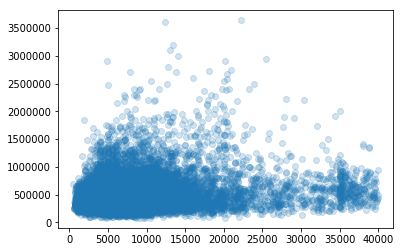

In [40]:
create_plot('sqft_lot')

Dont include: 
* view 
* lat 
* long
* zipcode
* sqft_living15
* sqft_lot15

### Notes:
* there are no duplicates
* waterfront only had 146 affirmative values, so I filled the nulls (2736) with negative values
* did the same with view & yr_renovated
* Removed outliers from bedrooms ( >7 rooms)
* Removed outliers from price ( >3840000)
* removed outliers from grade ( >11 & 4 (only one value for 4))
* removed outliers from sqft_living ( >6000)

### Questions to be answered by EDA 

* Are there null values that need to be taken care of?
* Are there outliers that are throwing off normal-ish distribution?
* Is there multicolinearity among predictor variables?
* Do any of the predictor variables need to be transformed/normalized/standardized?

In [266]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17890 entries, 0 to 21595
Data columns (total 43 columns):
price            17890 non-null float64
sqft_living      17890 non-null float64
sqft_lot         17890 non-null float64
sqft_above       17890 non-null float64
sqft_basement    17890 non-null float64
yr_built         17890 non-null int64
yr_renovated     17890 non-null float64
zipcode          17890 non-null int64
lat              17890 non-null float64
long             17890 non-null float64
sqft_living15    17890 non-null int64
sqft_lot15       17890 non-null int64
date             17890 non-null datetime64[ns]
bed_1            17890 non-null uint8
bed_2            17890 non-null uint8
bed_3            17890 non-null uint8
bed_4            17890 non-null uint8
bed_5            17890 non-null uint8
bed_6            17890 non-null uint8
bed_7            17890 non-null uint8
bath_1.0         17890 non-null uint8
bath_1.25        17890 non-null uint8
bath_1.5         17890 non-nul

In [264]:
df_pred = df.loc[:, ['yr_built', 'bedrooms', 'sqft_living', 'grade', 'sqft_living15', 'sqft_lot', 'bathrooms']]

/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


### Scatter matrix with raw variables

ValueError: zero-size array to reduction operation minimum which has no identity

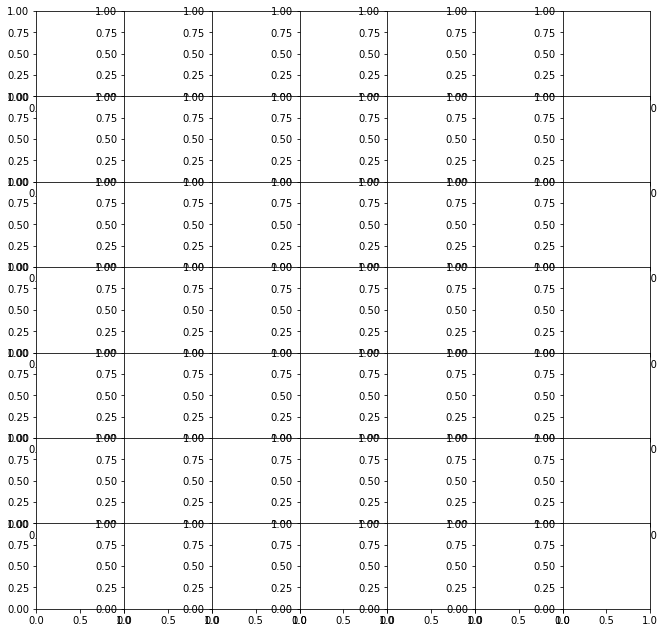

In [265]:
pd.plotting.scatter_matrix(df_pred, figsize=(11,11));

In [585]:
df_pred.corr() > .75

,yr_built,bedrooms,sqft_living,grade,sqft_living15,sqft_lot,bathrooms
yr_built,True,False,False,False,False,False,False
bedrooms,False,True,False,False,False,False,False
sqft_living,False,False,True,False,True,False,False
grade,False,False,False,True,False,False,False
sqft_living15,False,False,True,False,True,False,False
sqft_lot,False,False,False,False,False,True,False
bathrooms,False,False,False,False,False,False,True


In [263]:
plt.figure(figsize=(10,7))
sns.heatmap(df_pred.corr(), center=0, cmap=sns.color_palette('coolwarm'))

NameError: name 'df_pred' is not defined

<Figure size 720x504 with 0 Axes>

(array([3931., 8752., 4640., 1323.,  582.,  322.,  185.,  116.,  226.,
         169.]),
 array([  520.,  4464.,  8408., 12352., 16296., 20240., 24184., 28128.,
        32072., 36016., 39960.]),
 <a list of 10 Patch objects>)

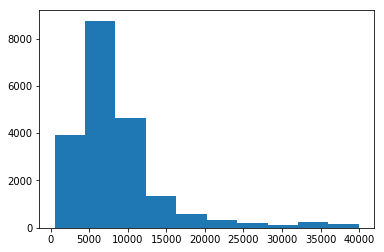

In [498]:
plt.hist(df.sqft_lot)

In [412]:
from statsmodels.formula.api import ols

In [275]:
target = 'price'
x_cols = ['sqft_living', 'grade']
predictors = '+'.join(x_cols)
formula = target + "~" + predictors
model = ols(formula=formula, data=df).fit()
model.summary()

PatsyError: Error evaluating factor: NameError: name 'grade' is not defined
    price~sqft_living+grade
                      ^^^^^

### Making a second experimental dataframe and transforming variables

In [402]:
df2 = df.copy()

In [406]:
# nn = ['price', 'sqft_living']
# for thing in nn:
#     df2[thing] = df2[thing].map(lambda x: np.log(x))


# code has been run

### Scatter matrix with log variables (price and sqft_living)

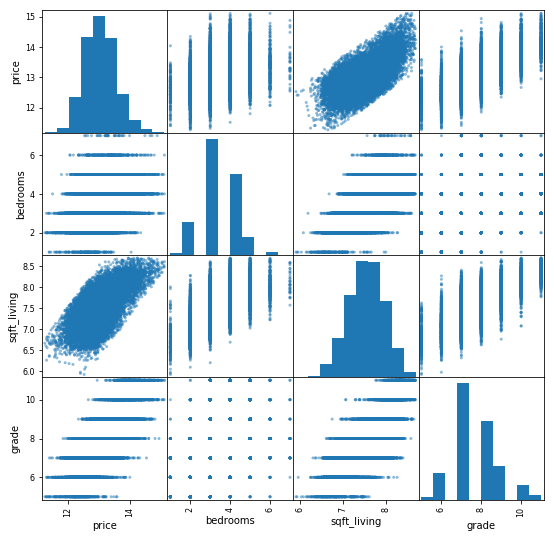

In [410]:
pd.plotting.scatter_matrix(df2_pred, figsize=(9,9));

In [385]:
abs(df2.corr()) > 0.75

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
id,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
price,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
bedrooms,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
bathrooms,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
sqft_living,False,False,False,True,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False
sqft_lot,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
floors,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False
waterfront,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
view,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False
condition,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False


### Getting the seasons experiment

In [114]:
def get_season(data):
    for thing in data:
        if thing.dt.month_name() == ['December', 'Janary', 'February']:
            return 'Winter'

In [116]:
import datetime

In [138]:
df.date.describe()

count                   17890
unique                    369
top       2014-06-23 00:00:00
freq                      117
first     2014-05-02 00:00:00
last      2015-05-27 00:00:00
Name: date, dtype: object

In [139]:
df.date.dtype

dtype('<M8[ns]')

In [140]:
print(df.date.dtype)

datetime64[ns]


In [130]:
df.date.dt.month_name().head()

0     October
1    December
2    February
3    December
4    February
Name: date, dtype: object

In [99]:
df2['seasons'] = df.date.dt.month_name()
df2.head()

,price,sqft_living,sqft_lot,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,...,cond_4,cond_5,grd_5,grd_6,grd_7,grd_8,grd_9,grd_10,grd_11,seasons
0,221900.0,1180,5650,1180,0.0,1955,0.0,98178,47.5112,-122.257,...,0,0,0,0,1,0,0,0,0,October
1,538000.0,2570,7242,2170,400.0,1951,1991.0,98125,47.7210,-122.319,...,0,0,0,0,1,0,0,0,0,December
2,180000.0,770,10000,770,0.0,1933,0.0,98028,47.7379,-122.233,...,0,0,0,1,0,0,0,0,0,February
3,604000.0,1960,5000,1050,910.0,1965,0.0,98136,47.5208,-122.393,...,0,1,0,0,1,0,0,0,0,December
4,510000.0,1680,8080,1680,0.0,1987,0.0,98074,47.6168,-122.045,...,0,0,0,0,0,1,0,0,0,February


### no more seasons experiment